# `StableSpectralElements.jl` - 1D Burgers' flux-differencing test

We first need to load StableSpectralElements.jl and OrdinaryDiffEq, which handle the spatial and temporal components of the discretization, respectively. The packages on the second line are used in this example for visualization and displaying timing information.

In [15]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, Printf, TimerOutputs

We will solve the one-dimensional Burgers' equation,
    $$\partial_t U(x,t) + \partial_x \big( \tfrac{1}{2} U(x,t)^2\big) = 0, \quad \forall \, (x,t) \in (0,L) \times (0,T), $$
with $L = 2$, $T = 0.3$, periodic boundary conditions, and an initial condition given following [Gassner (2013)](https://epubs.siam.org/doi/10.1137/120890144) by
$$ U(x,0) = \sin(\pi x) + 0.01.$$

In [16]:
L = 2.0  # domain length
T = 0.3  # end time for one period

conservation_law = InviscidBurgersEquation()
initial_data = InitialDataGassner(π,0.01);

The problem described above will be discretized using a flux-differencing DG method of `NodalTensor` type on a uniform mesh with $M = 20$ elements of degree $p = 7$. This is equivalent to the skew-symmetric form in this case, but generalizes to encompass a wide variety of split-form and entropy-stable schemes. We will use an entropy-conservative interface flux to obtain a scheme which conserves the energy/entropy $\frac{1}{2} \int_{0}^L U(x,t)^2 \, \mathrm{d} x$. An entropy-dissipative scheme could alternatively be obtained by choosing `inviscid_numerical_flux=LaxFriedrichsNumericalFlux()` instead.

In [17]:
M = 20
p = 7
form = FluxDifferencingForm(inviscid_numerical_flux=EntropyConservativeNumericalFlux())

reference_approximation = ReferenceApproximation(NodalTensor(p), Line())

mesh = uniform_periodic_mesh(reference_approximation, (0.0,L), M)

spatial_discretization = SpatialDiscretization(mesh, reference_approximation);

We'll now save the project. This sets up a directory where intermediate solution files are saved, and allows the simulation to be resumed from a previous state.

In [18]:
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T),
     "results/burgers_1d/", clear=true, overwrite=true);

The function `semidiscretize` sets up the solver using the above parameters and uses it to construct an `ODEProblem` object. We can then use `solve` from OrdinaryDiffEq.jl to integrate in time. The five-stage, fourth-order low-storage explicit Runge-Kutta method from Carpenter and Kennedy is used for such a purpose. We use `save_callback` to write the solution to file 50 times during the course of the simulation.

In [19]:
ode_problem = semidiscretize(conservation_law, spatial_discretization,
    initial_data, form, (0.0, T))

CFL = 0.1
h = L / (reference_approximation.N_p * spatial_discretization.N_e)
dt = CFL * h / 1.0

reset_timer!()
sol = solve(ode_problem, CarpenterKennedy2N54(), adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, (0.0,T),  
        floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            151ms /  80.4%            104MiB /  97.8%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 du/dt                  1.26k    121ms  100.0%  96.1μs    102MiB  100.0%  82.8KiB
   eval residual        1.26k    101ms   83.0%  79.8μs   99.1MiB   97.1%  80.4KiB
   reconstruct noda...  1.26k   20.1ms   16.5%  15.9μs   2.97MiB    2.9%  2.41KiB
 ────────────────────────────────────────────────────────────────────────────────


Using the snapshots taken during the simulation, the discrete conservation and energy functionals can be evaluated, corresponding to the discrete approximations of $\int_0^L U(x,t) \, \mathrm{d} x$ and $\tfrac{1}{2}\int_0^L U(x,t)^2 \, \mathrm{d} x$, respectively. Note that the conservation functional remains constant up to machine precision, while the energy functional decreases only due to the influence of the temporal discretization.

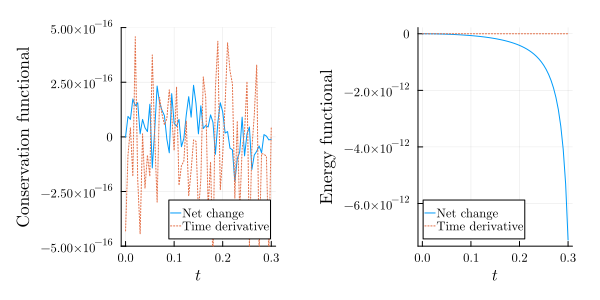

In [20]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
p1 = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Conservation functional", ylims=[-5e-16,5e-16])
p2 = plot(analyze(energy_analysis, load_time_steps(results_path)), 
    ylabel="Energy functional");
plot(p1,p2, size=(600,300),margin=5mm, fmt=:png)

Now we'll animate the evolution of the numerical solution over the time.

[ Info: Saved animation to /Users/tristanmontoya/Research/StableSpectralElements.jl/examples/burgers_solution.gif


Plots.AnimatedGif("/Users/tristanmontoya/Research/StableSpectralElements.jl/examples/burgers_solution.gif")
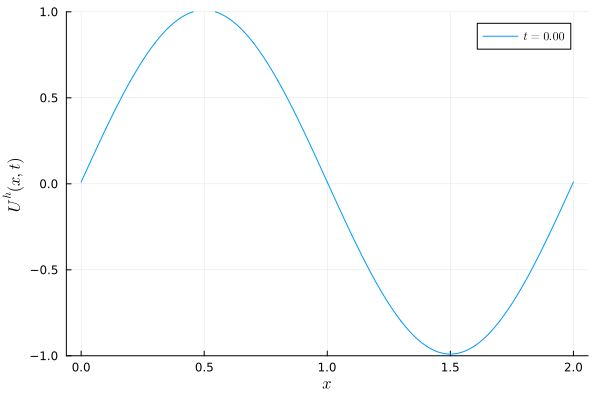

In [21]:
anim = @animate for i ∈ eachindex(sol.u)
    plot(spatial_discretization, sol.u[i], 
        ylims=[-1.0,1.0], ylabel="\$U^h(x,t)\$",
        label=string("\$t = \$", @sprintf "\$%.2f\$" sol.t[i]),
        legend=:topright)
end
gif(anim, "burgers_solution.gif", fps = 10)